# 🌍 IMAGE CLASSIFICATION - Workshop 3

**Students:** Paula Andrea Cardona Velásquez y Mario Alejandro Celis Torres

**Objective:** This notebook aims to develop a supervised land cover classification workflow using **Sentinel-2 imagery** and **machine learning models**. The process begins by generating monthly median composites from Sentinel-2 Surface Reflectance imagery for the year 2018 over a study area near Ibagué, Colombia. These composite images will serve as input for training **Random Forest** model. The results will be evaluated.

## 1. Sentinel-2 images search and download

In [ ]:
# Recarga desde disco

cache_dir = pathlib.Path("/notebooks/WORKSHOP_3/cache")
cls_cache = cache_dir / "cls_smpls_fnl_info.pkl"
vec_cache = cache_dir / "class_vec_sample_info.pkl"

if cls_cache.exists() and vec_cache.exists():
    with open(vec_cache, "rb") as f:
        class_vec_sample_info = pickle.load(f)
    with open(cls_cache, "rb") as f:
        cls_smpls_fnl_info = pickle.load(f)
    print("✅  Cache cargada, saltamos reconstrucción")
else:
    print("ℹ️  Cache no encontrada: ejecuta la celda A cuando crees los objetos")

In [3]:
import ee

# Authentication (just once)
ee.Authenticate()

True

In [4]:
# Initialization (every time GEE is needed)
ee.Initialize()

print("✅ Successfully Initialized")

✅ Successfully Initialized


In [5]:
import ee
import warnings

# 1. Load AOI
aoi = ee.FeatureCollection("projects/cover-map-project/assets/aoi_wgs84")

# 2. Load the harmonized Sentinel-2 SR collection (recommended)
s2_sr = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
         .filterBounds(aoi)
         .filterDate("2018-01-01", "2018-12-31")
         .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)))

# 3. Print image IDs and acquisition dates
ids = s2_sr.aggregate_array("system:index")
dates = s2_sr.aggregate_array("system:time_start").map(lambda t: ee.Date(t).format("YYYY-MM-dd"))

print("🛰️ Image IDs used:")
print(ids.getInfo())

print("\n📅 Acquisition dates:")
print(dates.getInfo())

🛰️ Image IDs used:
['20181227T151659_20181227T151707_T18NWH', '20181230T152639_20181230T152636_T18NVG', '20181230T152639_20181230T152636_T18NWG', '20181230T152639_20181230T152636_T18NWH', '20181230T152639_20181230T152636_T18NXG', '20181230T152639_20181230T152636_T18NXH']

📅 Acquisition dates:
['2018-12-27', '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30']


In [17]:
import datetime
import time

# Select only the relevant bands
selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
median_2018_selected = s2_sr.select(selected_bands).median().clip(aoi)

# Export image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=median_2018_selected,
    description='Median_2018_SR_selected',
    folder='GEE_exports',  # it is needed to make sure that this folder exists in the personal drive
    fileNamePrefix='median_2018_sr_selected',
    region=aoi.geometry(),
    scale=10,  # Lowest common resolution (10m)
    crs='EPSG:4326',
    maxPixels=1e13
)

task.start()
print("✅ Export task started at:", datetime.datetime.now().strftime("%H:%M:%S"))

# Monitor task status
while task.active():
    print("⏳ Export in progress... checking again in 30 seconds.")
    time.sleep(30)

# Print final status
state = task.status()['state']
print(f"\n📦 Task finished with state: {state}")
if state != 'COMPLETED':
    print("❌ The task failed or was cancelled.")
    print("Details:", task.status())
else:
    print("✅ Export completed successfully!")

✅ Export task started at: 22:32:17
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 seconds.
⏳ Export in progress... checking again in 30 se

## 1.1. Sentinel-2 images visualization

In [6]:
# Bands validation

import rasterio

img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_selected-0000000000-0000000000.tif"

with rasterio.open(img_path) as src:
    print("Band count:", src.count)
    print("Band names:", src.descriptions)

Band count: 6
Band names: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')


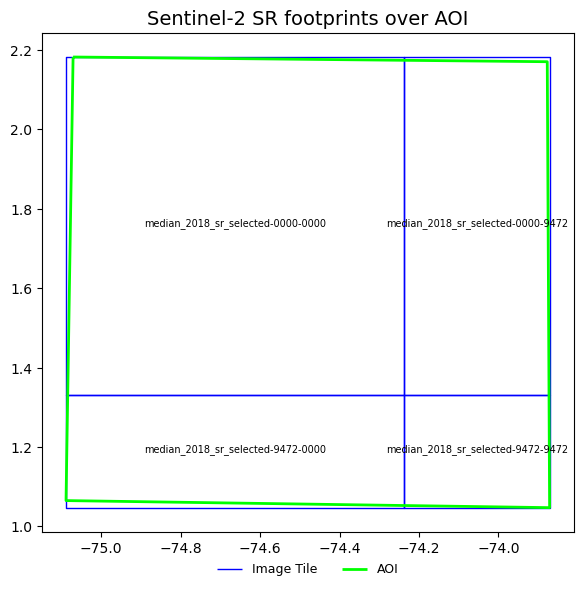

In [7]:
import os
import glob
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Paths
image_dir = r"/notebooks/WORKSHOP_3/images"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# AOI
aoi = gpd.read_file(aoi_path)

# image list
image_files = sorted(glob.glob(os.path.join(image_dir, "median_2018_sr_selected-*.tif")))

# footprints generation
footprints = []
names = []

for f in image_files:
    with rasterio.open(f) as src:
        bounds = src.bounds
        footprints.append(box(*bounds))
        # Extract the last two numeric blocks from the file name
        base = os.path.basename(f).replace('.tif', '')
        parts = base.split('-')
        shortname = f"{parts[0]}-{parts[-2][-4:]}-{parts[-1][-4:]}"
        names.append(shortname)

# GeoDataFrame
footprint_gdf = gpd.GeoDataFrame({'filename': names, 'geometry': footprints}, crs="EPSG:4326")

# footprints y AOI plot
fig, ax = plt.subplots(figsize=(6, 6))
footprint_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, label='Image Tile')
aoi.boundary.plot(ax=ax, edgecolor='lime', linewidth=2, label='AOI')

# Label each image with a simplified name
for idx, row in footprint_gdf.iterrows():
    ax.annotate(
        row["filename"], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),  # <- aquí estaba el problema
        fontsize=7, ha='center'
    )

plt.axis('equal') 

# Title
plt.title("Sentinel-2 SR footprints over AOI", fontsize=14)

# Horizontal legend below the chart
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), ncol=2, frameon=False, fontsize=9)

# styling
plt.axis('equal')
plt.tight_layout()
plt.show()

### 🧩 Merging Sentinel-2 Tiles from GEE Export

The 2018 median image was exported from Google Earth Engine (GEE) in four separate `.tif` tiles. These tiles represent different parts of the Area of Interest (AOI) and together form a single composite image.

Since they were exported already clipped to the AOI, it wasn't neede to crop them again. However, they were "merged" into one large file to be used for classification.

We used the `gdal_merge.py` tool in the terminal to combine them. To make the output more efficient, we used these options:
- `-of GTiff`: output format is GeoTIFF
- `-co COMPRESS=LZW`: apply compression
- `-co BIGTIFF=YES`: allow output larger than 4GB
- `-co TILED=YES`: optimize for reading in blocks
- `-a_nodata 0`: set no-data value to 0
- `-ot UInt16`: use 16-bit integer (Surface Reflectance values are integers)

### Terminal command:

```bash
gdal_merge.py -o median_2018_sr_merged.tif \
-of GTiff \
-co COMPRESS=LZW \
-co BIGTIFF=YES \
-co TILED=YES \
-a_nodata 0 \
-ot UInt16 \
median_2018_sr_selected-*.tif

### 💡 Additional note
Although the merging process could also be done in Python using `rasterio.merge`, I chose to do it via terminal with `gdal_merge.py` due to its efficiency, precise control over compression and `nodata` settings, and better handling of large files.

The resulting image `median_2018_sr_merged.tif` will be used as the main input for supervised classification models, as it consolidates all the spectral information from the AOI into a single, continuous, and consistent structure.

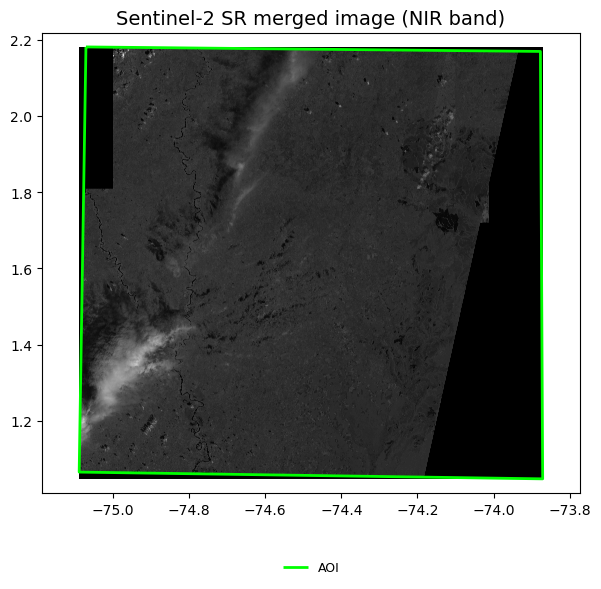

In [6]:
# Final image visaulization

import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

# Paths
img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# Load AOI
aoi = gpd.read_file(aoi_path)

# Load Band 4 (NIR)
with rasterio.open(img_path) as src:
    red_band = src.read(4) / 10000  # Normalized reflectance
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(red_band, cmap='gray', extent=extent)
aoi.boundary.plot(ax=ax, edgecolor='lime', linewidth=2, label='AOI')

# Styling
ax.set_title("Sentinel-2 SR merged image (NIR band)", fontsize=14)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=9, frameon=False)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2. Import modules for model training

In [8]:
# Base
import os
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Spatial analysis
import geopandas as gpd
import rasterio
from shapely.geometry import mapping

import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print("✅ Modules imported successfully")

✅ Modules imported successfully


In [9]:
import rasterio
import numpy as np

# Input image path
src_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# Output mask path
mask_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"

In [8]:
# Mask generation

# Abrir imagen y crear máscara binaria donde haya datos válidos
with rasterio.open(src_path) as src:
    img = src.read()  # (bands, height, width)
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1)

    # Crear máscara: 1 donde al menos un valor de banda sea > 0
    mask = np.any(img != 0, axis=0).astype(np.uint8)

# Guardar máscara
with rasterio.open(mask_path, "w", **profile) as dst:
    dst.write(mask, 1)

print("✅ Mask created successfully.")

NameError: name 'src_path' is not defined

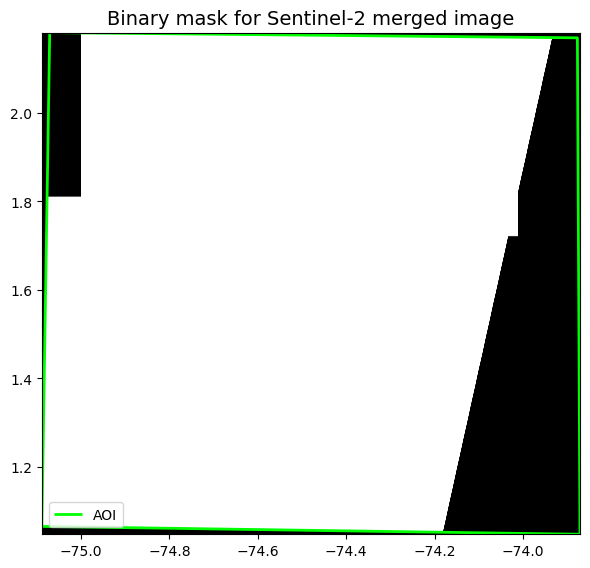

In [10]:
# Mask visualization

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio

# Paths
mask_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"
aoi_path = r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp"

# Load AOI
aoi = gpd.read_file(aoi_path)

# Load mask
with rasterio.open(mask_path) as src:
    mask = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mask, cmap="gray", extent=extent)
aoi.boundary.plot(ax=ax, edgecolor="lime", linewidth=2, label="AOI")
ax.set_title("Binary mask for Sentinel-2 merged image", fontsize=14)
ax.legend(loc="lower left")
ax.axis("on")
plt.tight_layout()
plt.show()

## 3. Allocate input data into variables

Declare the **core inputs** for the classification exercise:

| Variable | File | Purpose |
|----------|------|---------|
| `input_img` | `median_2018_sr_merged.tif` | Multispectral Sentinel-2 image (20 m resolution) to be classified. The image is surface-reflectance corrected and clipped to the AOI. |
| `in_msk_img` | `median_2018_sr_mask.tif  ` | Binary mask for the same image. It flags valid pixels (1) and invalid pixels (0) to be ignored. Required for consistent preprocessing. |
| `vec_train_file` | `datos_ent_val.gpkg ` | Vector file with **training polygons** and **testing points**, both labeled with land cover classes. These will be used to train and validate the classifier. |

In [11]:
# Allocate input paths to variables

input_img = "images/median_2018_sr_merged.tif"       # Merged Sentinel-2 SR image (2018)
in_msk_img = "images/median_2018_sr_mask.tif"        # Binary mask indicating valid pixels
vec_train_file = "datos_ent_val.gpkg"                # GPKG with training polygons and testing points

print("✅ Input paths set successfully.")

✅ Input paths set successfully.


## 4. Explore the data

Get the list of layers within the vector file.

In [12]:
from rsgislib import vectorutils

gpkg_path = r"/notebooks/WORKSHOP_3/datos_ent_val.gpkg"
lyr_names = vectorutils.get_vec_lyrs_lst(gpkg_path)
print("Layers in GPKG:", lyr_names)

Layers in GPKG: ['testing', 'training']


In [13]:
import geopandas as gpd

# Load each layer from the GeoPackage
gdf_train = gpd.read_file(gpkg_path, layer='training')
gdf_test = gpd.read_file(gpkg_path, layer='testing')

# Show unique classes in each layer
print("✅ Classes in training layer:", gdf_train["Name"].unique())
print("✅ Classes in testing layer:", gdf_test["Name"].unique())

# Count class samples in each layer
print("📊 Training class counts:\n", gdf_train["Name"].value_counts())
print("\n📊 Testing class counts:\n", gdf_test["Name"].value_counts())

✅ Classes in training layer: ['artificial_surfaces' 'agricultural_areas' 'forest'
 'shurb_and_herbaceous' 'water_bodies' 'secondary_vegetation'
 'sparsely_or_no_vegetated_areas']
✅ Classes in testing layer: ['agricultural_areas' 'forest' 'shrub_or_herbaceous_vegetation'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'clouds']
📊 Training class counts:
 Name
shurb_and_herbaceous              56
agricultural_areas                50
secondary_vegetation              32
water_bodies                       9
artificial_surfaces                7
forest                             5
sparsely_or_no_vegetated_areas     4
Name: count, dtype: int64

📊 Testing class counts:
 Name
forest                            44
sparsely_or_no_vegetated_areas    16
clouds                             9
agricultural_areas                 3
shrub_or_herbaceous_vegetation     3
secondary_vegetation               3
Name: count, dtype: int64


### ⚠️ **Note on training and testing data consistency**
>
> During the review of the training (polygon) and testing (point) layers, it was found that:
> - Two classes present in the training layer were missing from the testing layer: `artificial_surfaces` and `water_bodies`.
> - One class present in the testing layer was missing from the training layer: `clouds`.
>
> To ensure a consistent set of land cover classes across both datasets, these missing records were added manually to the `datos_ent_val.gpkg` file using QGIS.
>
> This step is essential to avoid errors during model training and evaluation, and to ensure proper computation of accuracy metrics.

In [15]:
from rsgislib import vectorutils

gpkg_path = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
lyr_names = vectorutils.get_vec_lyrs_lst(gpkg_path)
print("Layers in GPKG:", lyr_names)

Layers in GPKG: ['testing', 'training', 'agricultural_areas', 'forest', 'shurb_and_herbaceous', 'artificial_surfaces', 'water_bodies', 'secondary_vegetation', 'sparsely_or_no_vegetated_areas', 'clouds']


In [14]:
import geopandas as gpd

# Load each layer from the GeoPackage
gdf_train = gpd.read_file(gpkg_path, layer='training')
gdf_test = gpd.read_file(gpkg_path, layer='testing')

# Show unique classes in each layer
print("✅ Classes in training layer:", gdf_train["Name"].unique())
print("✅ Classes in testing layer:", gdf_test["Name"].unique())

# Count class samples in each layer
print("📊 Training class counts:\n", gdf_train["Name"].value_counts())
print("\n📊 Testing class counts:\n", gdf_test["Name"].value_counts())

✅ Classes in training layer: ['artificial_surfaces' 'agricultural_areas' 'forest'
 'shurb_and_herbaceous' 'water_bodies' 'secondary_vegetation'
 'sparsely_or_no_vegetated_areas']
✅ Classes in testing layer: ['agricultural_areas' 'forest' 'shrub_or_herbaceous_vegetation'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'clouds']
📊 Training class counts:
 Name
shurb_and_herbaceous              56
agricultural_areas                50
secondary_vegetation              32
water_bodies                       9
artificial_surfaces                7
forest                             5
sparsely_or_no_vegetated_areas     4
Name: count, dtype: int64

📊 Testing class counts:
 Name
forest                            44
sparsely_or_no_vegetated_areas    16
clouds                             9
agricultural_areas                 3
shrub_or_herbaceous_vegetation     3
secondary_vegetation               3
Name: count, dtype: int64


Sub-image bounding box: [-74.63205181   1.47283681 -74.32766034   1.75649115]


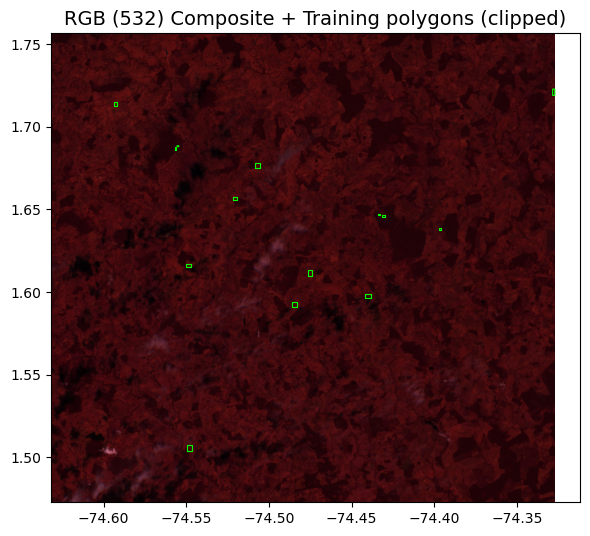

In [15]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# -------------------------------
# 1. AOI oand reduced bbox (25%)
aoi = gpd.read_file(r"/notebooks/WORKSHOP_3/AOI/aoi_wgs84.shp")
minx, miny, maxx, maxy = aoi.total_bounds

reduction_factor = 0.25
width = maxx - minx
height = maxy - miny
new_width = width * reduction_factor
new_height = height * reduction_factor
new_minx = minx + (width - new_width) / 2
new_maxx = new_minx + new_width
new_miny = miny + (height - new_height) / 2
new_maxy = new_miny + new_height

bbox_geom = box(new_minx, new_miny, new_maxx, new_maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=aoi.crs)
print("Sub-image bounding box:", bbox_gdf.total_bounds)

# -------------------------------
# 2. Load image and crop display to a reduced bounding box, to avoid kernel restart
img_path = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"
with rasterio.open(img_path) as src:
    window = src.window(new_minx, new_miny, new_maxx, new_maxy)
    red = src.read(5, window=window)
    green = src.read(3, window=window)
    blue = src.read(2, window=window)
    transform = src.window_transform(window)

# -------------------------------
# 3. Normalize bands and create RGB image
def normalize(band):
    return (band - band.min()) / (band.max() - band.min())

rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))

# -------------------------------
# 4. Load training layer and crop to reduced bbox
gdf_train = gpd.read_file(r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg", layer="training")
gdf_train_clip = gdf_train.cx[new_minx:new_maxx, new_miny:new_maxy]

# -------------------------------
# 5. Plot RGB image with training polygons
fig, ax = plt.subplots(figsize=(6, 6))
extent = [new_minx, new_maxx, new_miny, new_maxy]
ax.imshow(rgb, extent=extent)
gdf_train_clip.boundary.plot(ax=ax, edgecolor='lime', linewidth=0.8)
ax.set_title("RGB (532) Composite + Training polygons (clipped)", fontsize=14)
plt.tight_layout()
plt.show()

## Image and band definition

In [16]:
from rsgislib.imageutils import ImageBandInfo

# image path
input_img = r"/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# band definition: [R, G, B, NIR, SWIR1, SWIR2] → [3, 2, 1, 4, 5, 6]
img_band_info = []
img_band_info.append(
    ImageBandInfo(
        file_name=input_img,
        name="sentinel_2018",
        bands=[3, 2, 1, 4, 5, 6]
    )
)

print("Bandas definidas:", img_band_info)

Bandas definidas: [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]


In [17]:
# class import and list creation

from rsgislib.classification import ClassVecSamplesInfoObj

# List to store info by class
class_vec_sample_info = []

print("✅ List created successfully")
print(class_vec_sample_info)

✅ List created successfully
[]


In [18]:
from rsgislib.classification import ClassVecSamplesInfoObj
import inspect, textwrap, pprint

sig = inspect.signature(ClassVecSamplesInfoObj.__init__)
print("✔️  Signature supported by the installed rsgislib version:")
pprint.pprint(sig)

✔️  Signature supported by the installed rsgislib version:
<Signature (self, id=None, class_name=None, vec_file=None, vec_lyr=None, file_h5=None)>


In [19]:
# Salvavidas al renicio de Kernel

# ── Cachear objetos críticos ─────────────────────────────────────
import pickle, pathlib, datetime

cache_dir = pathlib.Path("/notebooks/WORKSHOP_3/cache")
cache_dir.mkdir(exist_ok=True)

with open(cache_dir / "class_vec_sample_info.pkl", "wb") as f:
    pickle.dump(class_vec_sample_info, f)

with open(cache_dir / "cls_smpls_fnl_info.pkl", "wb") as f:
    pickle.dump(cls_smpls_fnl_info, f)

print("✅  Objetos cacheados —", datetime.datetime.now().strftime("%H:%M:%S"))

✅  Objetos cacheados — 00:43:30


In [20]:
# Extraction of each layer in a single gpkg

import geopandas as gpd

src_gpkg   = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
dst_gpkg   = src_gpkg          
classes    = ["agricultural_areas", "forest", "shurb_and_herbaceous",
              "artificial_surfaces", "water_bodies",
              "secondary_vegetation", "sparsely_or_no_vegetated_areas",
              "clouds"]

gdf_train = gpd.read_file(src_gpkg, layer="training")

for cls in classes:
    gdf_cls = gdf_train[gdf_train["Name"] == cls]
    gdf_cls.to_file(dst_gpkg, layer=cls, driver="GPKG")
    print(f"✔️  layer '{cls}' escrito con {len(gdf_cls)} features")

✔️  layer 'agricultural_areas' escrito con 47 features
✔️  layer 'forest' escrito con 5 features
✔️  layer 'shurb_and_herbaceous' escrito con 54 features
✔️  layer 'artificial_surfaces' escrito con 4 features
✔️  layer 'water_bodies' escrito con 10 features
✔️  layer 'secondary_vegetation' escrito con 32 features
✔️  layer 'sparsely_or_no_vegetated_areas' escrito con 4 features
✔️  layer 'clouds' escrito con 12 features


In [21]:
# --------------------------------------------
# Define 8 classes and their HDF5 files
# --------------------------------------------

from rsgislib.classification import ClassVecSamplesInfoObj
vec_train_file   = r"/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
class_vec_sample_info = []

def add_class(id, lyr_name):
    class_vec_sample_info.append(
        ClassVecSamplesInfoObj(
            id=id,
            class_name=lyr_name,       
            vec_file=vec_train_file,
            vec_lyr=lyr_name,           
            file_h5=f"{lyr_name}_smpls.h5"
        )
    )

add_class(1, "agricultural_areas")
add_class(2, "forest")
add_class(3, "shurb_and_herbaceous")      
add_class(4, "artificial_surfaces")
add_class(5, "water_bodies")
add_class(6, "secondary_vegetation")
add_class(7, "sparsely_or_no_vegetated_areas")
add_class(8, "clouds")

print("✅  List reconstructed with independent layers")

✅  List reconstructed with independent layers


In [22]:
# Temporary directory creaction

import os
tmp_dir = r"/notebooks/WORKSHOP_3/tmp_training_data"

if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

print("✅ Temporary directory created successfully")

✅ Temporary directory created successfully


In [23]:
import rsgislib
print("Versión de RSGISLib:", rsgislib.__version__)

import rsgislib.classification.classsklearn as csk
print("\nContenido de rsgislib.classification.classssklearn:")
print("\n".join(dir(csk)))

Versión de RSGISLib: 5.1.7

Contenido de rsgislib.classification.classssklearn:
BaseEstimator
BaseSearchCV
Dict
List
TQDM_AVAIL
Union
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__spec__
applier
apply_sklearn_classifier
apply_sklearn_classifier_rat
feat_sel_sklearn_multiclass_borutashap
gdal
h5py
numpy
perform_sklearn_classifier_param_search
rat
ratapplier
rsgislib
tqdm
train_sklearn_classifier


In [24]:
import inspect
from rsgislib.classification import get_class_training_data

print("Firma de get_class_training_data:")
print(inspect.signature(get_class_training_data))

Firma de get_class_training_data:
(img_band_info: List[rsgislib.imageutils.ImageBandInfo], class_vec_sample_info: List[rsgislib.classification.ClassVecSamplesInfoObj], tmp_dir: str, sub_sample: int = None, ref_img: str = None) -> dict


In [25]:
from rsgislib.classification import get_class_training_data

get_class_training_data(
    img_band_info=img_band_info,
    class_vec_sample_info=class_vec_sample_info,
    tmp_dir=tmp_dir
)

print("✔ Extracción terminada – nuevos .h5 escritos en tmp_training_data")

Creating output image using input image0) /notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif

New image width = 13554 height = 12631 bands = 1


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and

In [26]:
from rsgislib.classification import get_num_samples

print("\n📊  Sample count per class class_vec_sample_info\n")
for cls in class_vec_sample_info:
    n = get_num_samples(cls.file_h5)
    print(f"{cls.class_name:35}: {n:8d}")


📊  Sample count per class class_vec_sample_info

agricultural_areas                 :    47511
forest                             :    24592
shurb_and_herbaceous               :    78968
artificial_surfaces                :     2206
water_bodies                       :     4510
secondary_vegetation               :     5487
sparsely_or_no_vegetated_areas     :      990
clouds                             :    16883


In [27]:
from rsgislib.classification import get_class_training_data

cls_smpls_info = get_class_training_data(
    img_band_info,          # ImageBandInfo list
    class_vec_sample_info,  # ClassVecSamplesInfoObj list
    tmp_dir=tmp_dir         # temporary folder for .h5 files
)
print("✅ Dictionary cls_smpls_info constructed")

0) /notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif
New image width = 13554 height = 12631 bands = 1

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Ru

In [28]:
# checkin classes after recreating dictionary

print("\n🔑  cls_smpls_info:\n")
for k in cls_smpls_info:
    print(" •", k)


🔑  cls_smpls_info:

 • agricultural_areas
 • forest
 • shurb_and_herbaceous
 • artificial_surfaces
 • water_bodies
 • secondary_vegetation
 • sparsely_or_no_vegetated_areas
 • clouds


In [29]:
# smpls.h5 localization

import glob, os
base_path = "/notebooks"             # raíz de tus cuadernos
found = glob.glob(os.path.join(base_path, "**/*_smpls.h5"), recursive=True)
print("\n".join(found) or "Nothing found")

/notebooks/workshop3-image-classification/agricultural_areas_smpls.h5
/notebooks/workshop3-image-classification/artificial_surfaces_smpls.h5
/notebooks/workshop3-image-classification/clouds_smpls.h5
/notebooks/workshop3-image-classification/forest_smpls.h5
/notebooks/workshop3-image-classification/secondary_vegetation_smpls.h5
/notebooks/workshop3-image-classification/shurb_and_herbaceous_smpls.h5
/notebooks/workshop3-image-classification/sparsely_or_no_vegetated_areas_smpls.h5
/notebooks/workshop3-image-classification/water_bodies_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/agricultural_areas_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/artificial_surfaces_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/clouds_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/forest_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/secondary_vegetation_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/shurb_and_herbaceous_smpls.h5
/notebooks/WORKSHOP_3/tmp_training12/sparsely_or_no_vegetated_areas_smpls.h5
/note

In [30]:
# Class colours definition

# -------------------------------------
# Dictionary {class_name: ((R, G, B), "Colour‐Name")}
cls_rgb = {
    "agricultural_areas"          : ((142,  28, 211), "Purple"),
    "forest"                      : ((155, 247,  20), "Lime-Green"),
    "shurb_and_herbaceous"        : ((219, 112, 255), "Magenta"),
    "artificial_surfaces"         : ((162, 208,   3), "Olive-Green"),
    "water_bodies"                : ((  0,   0, 255), "Blue"),
    "secondary_vegetation"        : ((249, 216,  62), "Mustard"),
    "sparsely_or_no_vegetated_areas":(( 38,  37, 122), "Indigo"),
    "clouds"                      : ((255, 255, 255), "White"),
}

# --- RGB and name for each object in class_vec_sample_info list ---
for cls in class_vec_sample_info:
    if cls.class_name not in cls_rgb:
        raise ValueError(f"⚠️ Falta color para la clase '{cls.class_name}'")

    # Este bloque debe tener la misma indentación que el 'if'
    (r, g, b), clr_name = cls_rgb[cls.class_name]

    # Saving the object properties
    cls.red = r
    cls.green = g
    cls.blue = b
    cls.colour_name = clr_name  # opcional, solo si lo quieres

print("\n✅ Colores asignados a todos los objetos")


✅ Colores asignados a todos los objetos


In [31]:
# Function to extract samples from each class

from rsgislib.classification import get_num_samples

print("\n📊  Sample count per class")
for cls in class_vec_sample_info:
    n = get_num_samples(cls.file_h5)
    print(f"{cls.class_name:35}: {n:8d}")


📊  Sample count per class
agricultural_areas                 :    47511
forest                             :    24592
shurb_and_herbaceous               :    78968
artificial_surfaces                :     2206
water_bodies                       :     4510
secondary_vegetation               :     5487
sparsely_or_no_vegetated_areas     :      990
clouds                             :    16883


In [32]:
# ----------------------------------------------
# Create / reuse a folder where the split files
# will be written
# ----------------------------------------------
import os

smpls_dir = r"/notebooks/WORKSHOP_3/cls_smpls"
os.makedirs(smpls_dir, exist_ok=True)
print("✅  sample-folder:", smpls_dir)

✅  sample-folder: /notebooks/WORKSHOP_3/cls_smpls


In [33]:
src_dir = "/notebooks/workshop3-image-classification"

for obj in class_vec_sample_info:
    obj.file_h5 = os.path.join(src_dir, f"{obj.class_name}_smpls.h5")

print("✅  file_h5 apunta ahora a", src_dir)

✅  file_h5 apunta ahora a /notebooks/workshop3-image-classification


In [34]:
# ----------------------------------------------
# Build the new dict with _train / _valid / _test
# ----------------------------------------------
from rsgislib.classification import get_class_info_dict

cls_smpls_info = get_class_info_dict(
   cls_smpls_info,
   smpls_dir
)

print("✅ keys:", list(cls_smpls_info.keys())[:3], "...")

0=1: (Train:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_valid.h5), (197, 17, 193)
1=2: (Train:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/forest_smpls_valid.h5), (83, 210, 210)
2=3: (Train:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/shurb_and_herbaceous_smpls_valid.h5), (148, 177, 196)
3=4: (Train:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_train.h5, Test:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_test.h5, Valid:/notebooks/WORKSHOP_3/cls_smpls/artificial_surfaces_smpls_valid.h5), (37, 194, 200)
4=5: (Train:/notebooks/WORKSHOP_3/cls_smpls/water_bodies_smpls_train.h

In [35]:
# Ya tengo cls_smpls_info con _train/_valid/_test.
# Lo duplico en la variable que el resto del notebook espera.
cls_smpls_fnl_info = cls_smpls_info

In [89]:
#from rsgislib.classification import create_train_valid_test_sets

# Fixed amounts (None for "the rest")
#n_test  = 200
#n_valid = 200
#n_train = None   # Remaining samples

#create_train_valid_test_sets(
#    cls_in_info  = cls_smpls_info,      # <-- dict ClassSimpleInfoObj 
#    cls_out_info = cls_smpls_fnl_info,  # <-- dict generated with get_class_info_dict
#    test_sample  = n_test,
#    valid_sample = n_valid,
#    train_sample = n_train,
#    rnd_seed     = 42,
#    datatype     = None   
#)

#print("✅ HDF5 de Train/Valid/Test creados en:", smpls_dir)

### Random Forest Training

In [36]:
# Hyperparameter Optimization

# Grid-search on Random Forest  ✅
from rsgislib.classification.classsklearn import (
    perform_sklearn_classifier_param_search
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# ← search grid
param_grid = {
    "n_estimators": [ 50, 100, 150, 200],
    "max_depth"   : [ 8, 12, 16],
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    n_jobs = -1,      
    cv     = 5,       
)

sk_classifier = perform_sklearn_classifier_param_search(
    cls_smpls_fnl_info,
    grid_search
)

print("\n🎯 Best score :", grid_search.best_score_)
print("🔧 Best params:", grid_search.best_params_)

Training data size: 1700 x 6
Best score was 0.8570588235294118 and has parameters {'max_depth': 12, 'n_estimators': 100}.

🎯 Best score : 0.8570588235294118
🔧 Best params: {'max_depth': 12, 'n_estimators': 100}


In [37]:
from joblib import dump
from pathlib import Path

# 1.1 Folder where the model will be saved
models_dir = Path("/notebooks/WORKSHOP_3/models")
models_dir.mkdir(exist_ok=True)

# 1.2 File name
rf_model_path = models_dir / "rf_best.joblib"

# 1.3 Save the model with joblib.dump
dump(sk_classifier, rf_model_path)
print(f"✅ RF model saved → {rf_model_path}")

✅ RF model saved → /notebooks/WORKSHOP_3/models/rf_best.joblib


In [38]:
# Preparing band information for classification (ImageBandInfo))

from rsgislib.imageutils import ImageBandInfo

# 2.1 Route to the image to be classified
mos_path = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

band_names = ['B2','B3','B4','B8','B11','B12']
img_band_info = [
    ImageBandInfo(
        file_name = mos_path,
        name      = "sentinel_2018",
        bands     = [3, 2, 1, 4, 5, 6]
    )
]
print("✅ ImageBandInfo list:", img_band_info)

✅ ImageBandInfo list: [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]


In [92]:
from joblib import load
from pathlib import Path
from rsgislib.classification.classsklearn import apply_sklearn_classifier
from rsgislib.imageutils import ImageBandInfo

# ——————————————————————————————
# 1) Load the trained Random Forest model
# ——————————————————————————————
rf_model_path = Path("/notebooks/WORKSHOP_3/models/rf_best.joblib")
sk_classifier = load(str(rf_model_path))


# ——————————————————————————————
# 2) Input/output paths
# ——————————————————————————————
mos_path    = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"   # tu mosaico Sentinel-2
mask_path   = "/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"     # la máscara 0/1 que ya tenías
out_cls_img = "/notebooks/WORKSHOP_3/results/rf_classification.kea"      # salida en KEA


# ——————————————————————————————
# 3) List ImageBandInfo rebuilding

img_band_info = [
    ImageBandInfo(
        file_name = mos_path,
        name      = "sentinel_2018",
        bands     = [3, 2, 1, 4, 5, 6]
    )
]
print(f"✅ ImageBandInfo list:  {img_band_info}")


# ——————————————————————————————
# 4) apply_sklearn_classifier (gdalformat="KEA" instead of "GTiff")
# ——————————————————————————————
apply_sklearn_classifier(
    cls_train_info        = cls_smpls_fnl_info,  # HDF5 (train/valid/test)
    sk_classifier         = sk_classifier,       # RandomForest
    in_msk_img            = str(mask_path),      # TIFF mask (0/1)
    img_msk_val           = 1,                   # only == 1 pixels
    img_file_info         = img_band_info,       # List ImageBandInfo
    out_class_img         = str(out_cls_img),    # output path (.kea)
    gdalformat            = "KEA",               
    class_clr_names       = False,               
    out_score_img         = None,                
    ignore_consec_cls_ids = False                
)

print(f"✅ Classification saved → {out_cls_img}")

✅ ImageBandInfo list:  [('sentinel_2018', [3, 2, 1, 4, 5, 6], '/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif')]
Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

✅ Classification saved → /notebooks/WORKSHOP_3/results/rf_classification.kea


### Results visualization

In [39]:
# Import libraries and define file paths + clipping window

# Import needed libraries
import numpy as np
import rasterio
from rasterio.windows import Window
import os

# Define file paths for the median image and the classified output
# ------------------------------------------------------------------------
# Path to the median image that will be classified
img_mediana_fp = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"

# Path to the classified result (KEA) produced by the RF model
cls_predicted_fp = "/notebooks/WORKSHOP_3/results/rf_classification.kea"

# Define the clipping window (row_off, col_off, width, height)
# ------------------------------------------------------------------
# row_off: starting row index (pixel)
# col_off: starting column index (pixel)
# win_width: width of the window (number of pixels)
# win_height: height of the window (number of pixels)

row_off    = 2000   # <— first row of the window (adjust to your area of interest)
col_off    = 3500   # <— first column of the window (adjust to your area of interest)
win_width  = 500    # <— width of the snippet in pixels
win_height = 500    # <— height of the snippet in pixels

# Construct the rasterio Window object
window = Window(col_off, row_off, win_width, win_height)

# Check that both files exist (this helps catch wrong file paths)
# ----------------------------------------------------------------------
print("✅ Checking file existence:")
print("   Median image exists?      ", os.path.exists(img_mediana_fp))
print("   Classified image exists?  ", os.path.exists(cls_predicted_fp))
print("✅ Window defined → Row offset:", row_off, 
      "Col offset:", col_off, "Width:", win_width, "Height:", win_height)

✅ Checking file existence:
   Median image exists?       True
   Classified image exists?   True
✅ Window defined → Row offset: 2000 Col offset: 3500 Width: 500 Height: 500


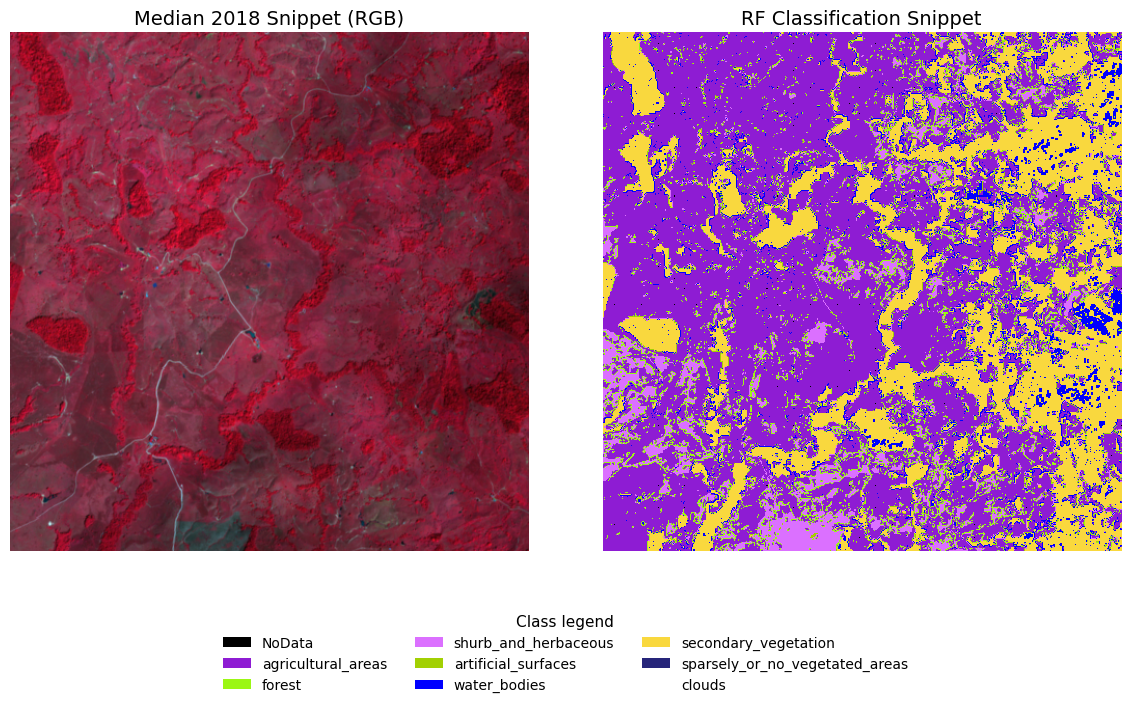

In [40]:
# -------------------------------------------------------------------
# Read clipped window from both rasters and plot side by side,
# -------------------------------------------------------------------

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.windows import Window
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# Band normalization
def normalize_band(band):
    """
    Normalize a 2D numpy array to the range [0,1], preserving dtype float.
    """
    minv = band.min()
    maxv = band.max()
    if maxv - minv == 0:
        return np.zeros_like(band, dtype="float32")
    return (band.astype("float32") - float(minv)) / float(maxv - minv)

# 2) Snippet (window) of Sentinel-2 merged
with rasterio.open(img_mediana_fp) as src_med:
    red_snip   = src_med.read(4, window=window)  # R
    green_snip = src_med.read(3, window=window)  # G
    blue_snip  = src_med.read(2, window=window)  # B

rgb_snip = np.dstack([
    normalize_band(red_snip),
    normalize_band(green_snip),
    normalize_band(blue_snip)
])

# 4) Snippet (window) of classification (KEA)
with rasterio.open(cls_predicted_fp) as src_cls:
    cls_snip = src_cls.read(1, window=window)  # Valores de clase (0..8)

# 5) ListedColormap according to cls_rgb
cls_rgb = {
    "agricultural_areas"            : (142,  28, 211),
    "forest"                        : (155, 247,  20),
    "shurb_and_herbaceous"          : (219, 112, 255),
    "artificial_surfaces"           : (162, 208,   3),
    "water_bodies"                  : (  0,   0, 255),
    "secondary_vegetation"          : (249, 216,  62),
    "sparsely_or_no_vegetated_areas": ( 38,  37, 122),
    "clouds"                        : (255, 255, 255)
}

ordered_keys = [
    "agricultural_areas",
    "forest",
    "shurb_and_herbaceous",
    "artificial_surfaces",
    "water_bodies",
    "secondary_vegetation",
    "sparsely_or_no_vegetated_areas",
    "clouds"
]

# List of colours
col_list = [(0.0, 0.0, 0.0)] 

for key in ordered_keys:
    r, g, b = cls_rgb[key]
    col_list.append((r/255.0, g/255.0, b/255.0))

cmap_cls = ListedColormap(col_list)
bounds = np.arange(len(col_list) + 1)  # [0,1,2,...,9]
norm  = BoundaryNorm(bounds, cmap_cls.N)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Snippet RGB (left)
ax1.imshow(rgb_snip)
ax1.set_title("Median 2018 Snippet (RGB)", fontsize=14)
ax1.axis("off")

# Snippet classification (right)
im2 = ax2.imshow(cls_snip, cmap=cmap_cls, norm=norm)
ax2.set_title("RF Classification Snippet", fontsize=14)
ax2.axis("off")

# Leyend
legend_items = []
for idx, class_name in enumerate(["NoData"] + ordered_keys):
    color = col_list[idx]
    legend_items.append(Patch(facecolor=color, edgecolor="none", label=class_name))

#    - Subplot_adjust aumenta el espacio inferior (bottom) para la leyenda
#    - BBox_to_anchor coloca la leyenda justo por debajo
fig.tight_layout(rect=[0, 0.08, 1, 1])  

fig.legend(
    handles=legend_items,
    title="Class legend",
    bbox_to_anchor=(0.5, 0.02), 
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

plt.show()

In [41]:
#HDF5 structure

import h5py

test_fp = "/notebooks/WORKSHOP_3/cls_smpls/agricultural_areas_smpls_test.h5"

with h5py.File(test_fp, "r") as f:
    print("Top-level keys in HDF5:", list(f.keys()))
    if "DATA" in f:
        print("\nInside 'DATA' group:", list(f["DATA"].keys()))
        print("\nShape of the array:", f["DATA"]["DATA"].shape)

Top-level keys in HDF5: ['DATA', 'META-DATA']

Inside 'DATA' group: ['DATA']

Shape of the array: (238, 6)


In [42]:
import geopandas as gpd

# 1.1) Path pf GeoPackage
gpkg_path = "/notebooks/WORKSHOP_3/datos_ent_val_2.gpkg"
layer_testing = "testing"   # nombre exacto de la capa que contiene los puntos de validación

gdf_test = gpd.read_file(gpkg_path, layer=layer_testing)

print("Number of validation points:", len(gdf_test))
print("Columns in testing layer:", list(gdf_test.columns))

print("Unique true classes in points:", gdf_test["Name"].unique())

Number of validation points: 93
Columns in testing layer: ['Reference', 'Name', 'geometry']
Unique true classes in points: ['artificial_surfaces' 'clouds' 'forest' 'shurb_and_herbaceous'
 'sparsely_or_no_vegetated_areas' 'secondary_vegetation' 'water_bodies']


In [43]:
import rasterio

# Classification path (rf_classification.kea)
cls_raster_fp = r"/notebooks/WORKSHOP_3/results/rf_classification.kea"

src = rasterio.open(cls_raster_fp)

print("Raster CRS:", src.crs)
print("Raster width, height:", src.width, src.height)
print("Raster nodata:", src.nodatavals)

Raster CRS: EPSG:4326
Raster width, height: 13554 12631
Raster nodata: (0.0,)


In [44]:
import numpy as np

# 3. CRS validation
if gdf_test.crs != src.crs:
    gdf_test = gdf_test.to_crs(src.crs)
    print("Reprojected validation points to match raster CRS.")

# Lists to collect true and predicted labels
y_true_list = []
y_pred_list = []

for idx, row in gdf_test.iterrows():
    # True class name from attribute "Name"
    true_class_name = row["Name"]
    y_true_list.append(true_class_name)

    # Point coordinate (x, y)
    x, y = row.geometry.x, row.geometry.y
    
    raster_value = list(src.sample([(x, y)]))[0][0]
    y_pred_list.append(raster_value)

# NumPy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

print("Extracted", len(y_true), "true labels and", len(y_pred), "predictions.")

Extracted 93 true labels and 93 predictions.


In [45]:
# --------------------------------------------
# Build a mapping from class name to integer code
# --------------------------------------------
class_to_code = {
    "agricultural_areas"           : 1,
    "forest"                       : 2,
    "shurb_and_herbaceous"         : 3,
    "artificial_surfaces"          : 4,
    "water_bodies"                 : 5,
    "secondary_vegetation"         : 6,
    "sparsely_or_no_vegetated_areas": 7,
    "clouds"                       : 8
}

code_to_class = {v: k for k, v in class_to_code.items()}

In [46]:
# --------------------------------------------
# Map true class names (strings) to integer codes
# --------------------------------------------
y_true_ids = np.array([class_to_code[name] for name in y_true])

print("First five true names:", y_true[:5])
print("First five true codes:", y_true_ids[:5])

First five true names: ['artificial_surfaces' 'artificial_surfaces' 'clouds' 'forest' 'forest']
First five true codes: [4 4 8 2 2]


### Confusion/error Matrix

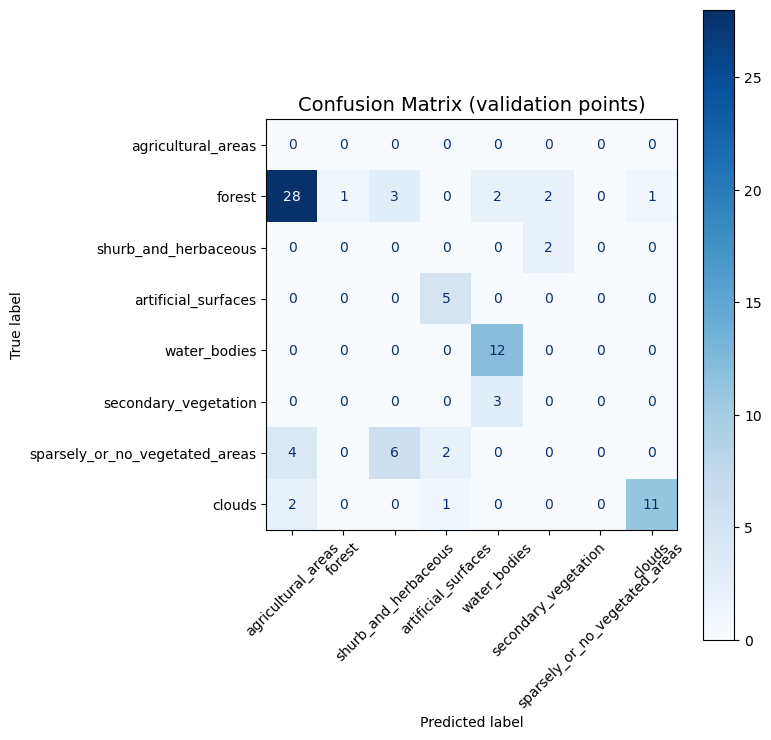

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --------------------------------------------
# Compute confusion matrix
# --------------------------------------------
cm = confusion_matrix(y_true_ids, y_pred, labels=list(class_to_code.values()))

# Create a display object for visualization
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[code_to_class[c] for c in sorted(code_to_class)]
)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
ax.set_title("Confusion Matrix (validation points)", fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
# --------------------------------------------
#Classification report and accuracy
# --------------------------------------------
acc = accuracy_score(y_true_ids, y_pred)
print(f"Overall accuracy: {acc:.4f}\n")

# classification_report imprimirá Precision, Recall, F1-score por clase
report = classification_report(
    y_true_ids,
    y_pred,
    labels=list(class_to_code.values()),
    target_names=[code_to_class[c] for c in sorted(code_to_class)],
    zero_division=0
)
print("Classification Report:\n")
print(report)

Overall accuracy: 0.3118

Classification Report:

                                precision    recall  f1-score   support

            agricultural_areas       0.00      0.00      0.00         0
                        forest       1.00      0.03      0.05        40
          shurb_and_herbaceous       0.00      0.00      0.00         3
           artificial_surfaces       0.62      1.00      0.77         5
                  water_bodies       0.71      1.00      0.83        12
          secondary_vegetation       0.00      0.00      0.00         3
sparsely_or_no_vegetated_areas       0.00      0.00      0.00        16
                        clouds       0.92      0.79      0.85        14

                     micro avg       0.34      0.31      0.33        93
                     macro avg       0.41      0.35      0.31        93
                  weighted avg       0.69      0.31      0.30        93



- **Lo que mejor clasifica**:  
  - _artificial_surfaces_ y _water_bodies_ (ambas con recall=1.00).  
  - _clouds_ sale casi perfecta (precision alta).  

- **Lo que peor**:  
  - _forest_ nunca la atina (recall=0).  
  - _shrub_and_herbaceous_, _secondary_vegetation_ y _sparsely_or_no_vegetated_areas_ tampoco.

El modelo **no es una maravilla :(**: solo acierta cerca del 30 % de los puntos, y varias clases se confunden por completo (especialmente “bosque” y “arbustales/herbáceas”).  
Sin embargo, **lo mejor** que hace es identificar bien las _superficies artificiales_ y los _cuerpos de agua_, seguido de las _nubes_. Todo lo demás termina siendo una caca de confusión.

- **What it classifies best**:
  - _artificial_surfaces_ and _water_bodies_ (both with recall=1.00).
  - _clouds_ are almost perfectly classified (high precision).

- **What it classifies worst**:
  - _forest_ is never correctly identified (recall=0).
  - _shrub_and_herbaceous_, _secondary_vegetation_, and _sparsely_or_no_vegetated_areas_ are also poorly classified.

The model **isn't great :(**; it only correctly classifies around 30% of the points, and several classes are completely confused (particularly "forest" and "shrub/herbaceous areas").  
However, **the best aspect** is that it identifies _artificial surfaces_ and _water bodies_ correctly, followed by _clouds_. Everything else ends up being a confusing mess.

## K-Means

In [49]:
# Import libraries

# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.windows as rwin

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

print("✅ Modules imported successfully")

✅ Modules imported successfully


In [50]:
m_root=r'/notebooks/WORKSHOP_3/images'
raster_path = m_root+r'/median_2018_sr_merged.tif'# Path to the original image

#Path to an image subset (as the original one is too large)
rows, cols  = 800, 800 # subset size
subset_path = m_root+r'/subset_'+str(rows)+'.tif'

with rio.open(raster_path) as src:
    H, W = src.height, src.width
    win  = rwin.Window((W - cols)//2, (H - rows)//2, cols, rows)
    subset = src.read(window=win)
    meta   = src.meta.copy()
    meta.update({"height": rows,
                 "width":  cols,
                 "transform": src.window_transform(win),
                 "compress": "lzw",
                 "tiled": True})

with rio.open(subset_path, "w", **meta) as dst:
    dst.write(subset)

print("Subset written in →", subset_path)

# --- Print key metadata fields to understand what is stored ---
print("Subset metadata summary:")
print(f"  Dimensions    → {meta['width']} × {meta['height']} px")
print(f"  Band count    → {meta['count']} bands")
print(f"  CRS           → {meta['crs']}")
print(f"  Data type     → {meta['dtype']}")
print(f"  Transform     →\n    {meta['transform']}")

Subset written in → /notebooks/WORKSHOP_3/images/subset_800.tif
Subset metadata summary:
  Dimensions    → 800 × 800 px
  Band count    → 6 bands
  CRS           → EPSG:4326
  Data type     → uint16
  Transform     →
    | 0.00, 0.00,-74.52|
| 0.00,-0.00, 1.65|
| 0.00, 0.00, 1.00|


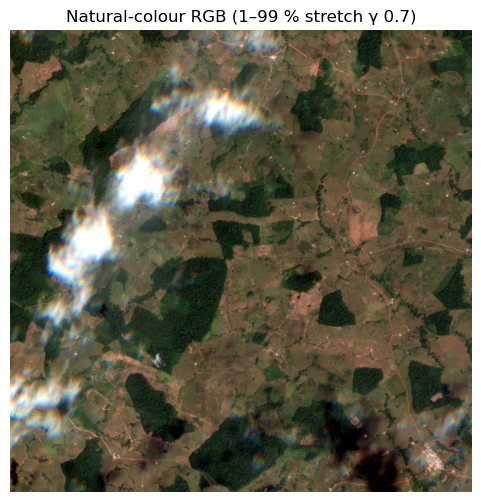

In [51]:
#· RGB preview (bands 4-3-2 )
with rio.open(subset_path) as src:
    img = src.read()

bands_rgb = (3, 2, 1)                            # R-G-B (1-based)
gamma     = 0.7                                 # contrast tweak

channels = []
for b in bands_rgb:
    band = img[b-1].astype(float)
    lo, hi = np.percentile(band, (1, 99))
    band = np.clip((band - lo) / (hi - lo), 0, 1)
    channels.append(band)

rgb = np.dstack(channels) ** gamma

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Natural-colour RGB (1–99 % stretch γ 0.7)")
plt.axis("off")
plt.show()

### Scatterplot

There are 6 bands in the image.


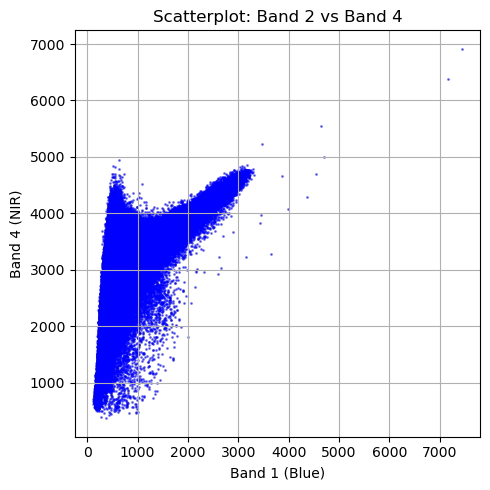

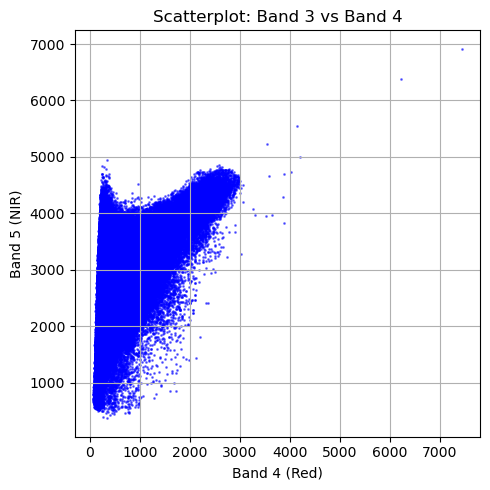

In [51]:
# Open the image
with rio.open(subset_path) as src:
    print(f'There are {src.count} bands in the image.')
    
# Read band 2 (index 2) and band 4 (index 4)
# rasterio uses indexes from 1
    
    band1 = src.read(1).astype(float)
    band2 = src.read(2).astype(float)
    band3 = src.read(3).astype(float)
    band4 = src.read(4).astype(float)
    band5 = src.read(5).astype(float)

# img uses indexes from 0

#   band1 = img[0].astype(float)
#   band2 = img[1].astype(float)
#   band3 = img[2].astype(float)
#   band4 = img[3].astype(float)

# Optional: mask null or unwanted values (e.g., <= 0)
mask = (band1 > 0) & (band4 > 0)
x = band2[mask].flatten()
y = band4[mask].flatten()


# Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(x, y, s=1, alpha=0.5, c='blue')
plt.xlabel('Band 1 (Blue)')
plt.ylabel('Band 4 (NIR)')
plt.title('Scatterplot: Band 2 vs Band 4')
plt.grid(True)
plt.tight_layout()
plt.show()

mask = (band4 > 0) & (band5 > 0)
x = band3[mask].flatten()
y = band4[mask].flatten()

# Scatterplot
plt.figure(figsize=(5,5))
plt.scatter(x, y, s=1, alpha=0.5, c='blue')
plt.xlabel('Band 4 (Red)')
plt.ylabel('Band 5 (NIR)')
plt.title('Scatterplot: Band 3 vs Band 4')
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# %% Listings 5-7 completos (adaptados)
class ClusteredStack:
    
    def __init__(self, raster_path): # Initialises the class instance.
        self.raster_path = raster_path # path to the multiband GeoTIFF (e.g., the 400×400 subset).  
        self.model_input = None #    the reshaped data matrix  
        self.height = self.width = self.depth = 0 # image dimensions
        self.k_range = [] # List of all k-values (number of clusters) to evaluate
        self.models = [] # Trained KMeans models for each k; stored for later inspection
        self.predicted_rasters = [] # Cluster label images (reshaped to raster size)
        self.inertia_scores = [] # Inertia values (sum of squared distances within clusters); used for Elbow method
        self.silhouette_scores = [] # Silhouette scores (measure of cluster separation); used for model selection

    
    def set_raster_stack(self):
        """Reads the raster and reshapes it into a format suitable for K-Means."""
        with rio.open(self.raster_path) as src:

            # Read all bands into a 3D NumPy array of shape (bands, rows, cols)
            stack = src.read()

             # Replace any NaN (Not-a-Number) values with zero. Avoids errors during clustering algorithms, which cannot handle NaNs
            stack = np.nan_to_num(stack)   
        # Extract the number of bands, rows, and columns from the raster's shape
        # These values are stored as object attributes for later use
        self.depth, self.height, self.width = stack.shape

        # Reshape the 3D array into a 2D matrix of shape (n_pixels, n_bands)
        # Each row now corresponds to one pixel, and each column to a spectral band
        # Transposition (.T) ensures the matrix has the correct shape for scikit-learn
        self.model_input = stack.reshape(self.depth, -1).T


    def build_models(self, k_values):
        """
            Trains one K-Means clustering model for each value of k provided in k_values.
         It stores the resulting models, cluster labels, and evaluation metrics.
        """

        # Convert the input iterable into a list and store it
        # This list defines the number of clusters to be tested (e.g. [3, 4, 5, ..., 10])
        self.k_range = list(k_values)

        # Initialise empty lists to store models, results, and metrics
        self.models, self.predicted_rasters = [], [] # Trained KMeans objects  - Cluster label images (reshaped to raster form)
        self.inertia_scores, self.silhouette_scores = [], [] # Inertia values for each k - # Silhouette scores for each k

        for k in self.k_range:

            # Create a KMeans model with k clusters
            # random_state ensures reproducibility; n_init specifies how many times the algorithm will run with different centroid seeds
            km = KMeans(n_clusters=k, random_state=42, n_init=10)

             # Fit the model to the reshaped raster and predict the cluster labels
             # This returns one label (cluster ID) per pixel
            labels = km.fit_predict(self.model_input)

            # Store the trained model
            self.models.append(km)

            # Record the inertia for this k (lower is better; used in Elbow method)
            self.inertia_scores.append(km.inertia_)

            # Calculate and store the silhouette score for this k
            # A higher silhouette score indicates better-defined clusters
            # Sampling is limited to 1000 points for performance reasons
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )

            # Reshape the flat list of labels back to image form (rows × cols)
            # This is required for visualising the classified image later
            self.predicted_rasters.append(labels.reshape(self.height, self.width))


    def show_clustered(self, cmap="Accent"):
        """
        Displays one classified raster image for each value of k.
        Each image uses a categorical colourmap for easy interpretation.
        """
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        """
        Plots the inertia values for each k to apply the Elbow method.
        Inertia measures how tightly the data points are clustered around their centroids.
        Lower values indicate more compact clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        """
        Plots the silhouette scores for each k to assess clustering quality.
        Silhouette score ranges from -1 to 1, with higher values indicating
        better-defined, well-separated clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Silhouette Coeff.s")
        plt.title("Silhouette scores")
        plt.show()

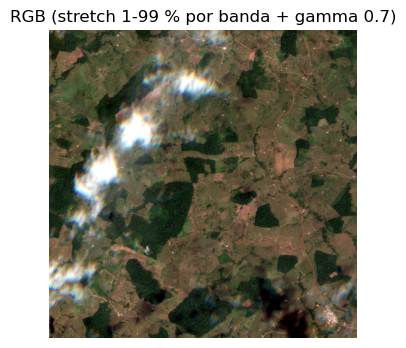

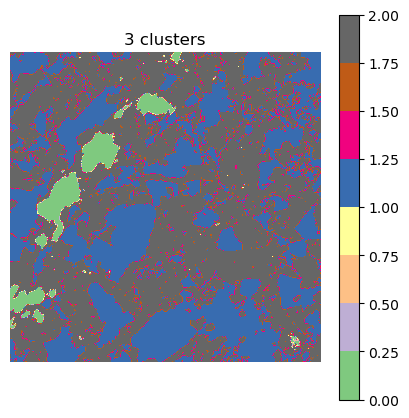

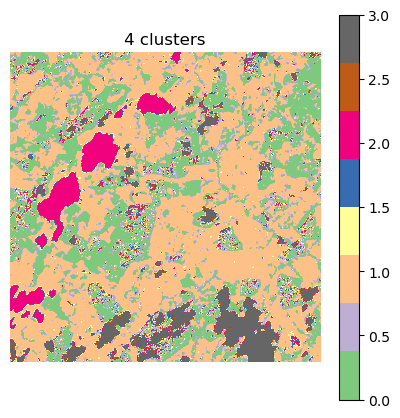

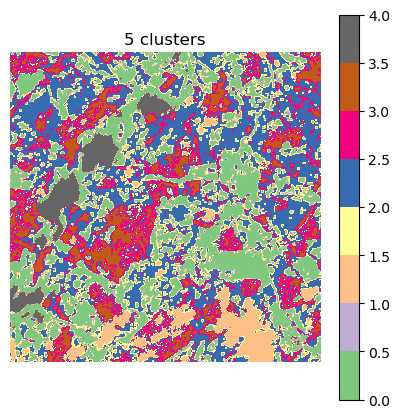

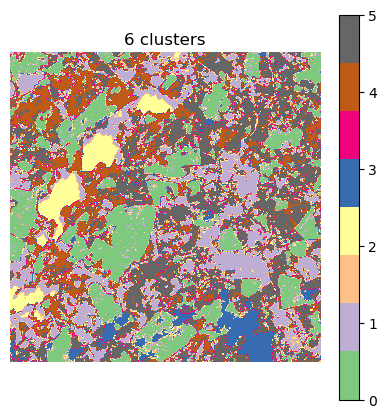

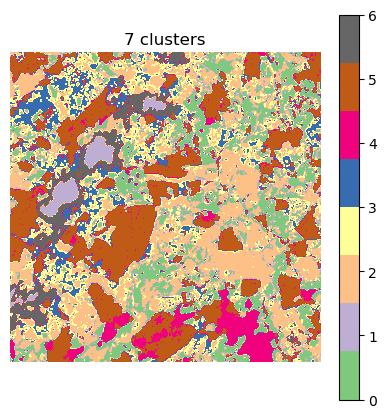

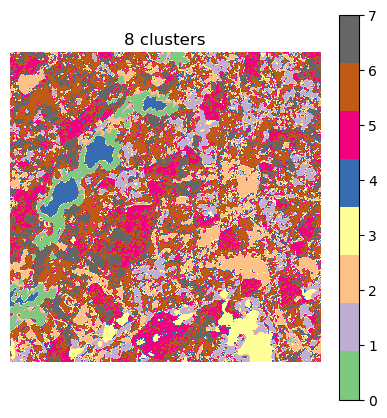

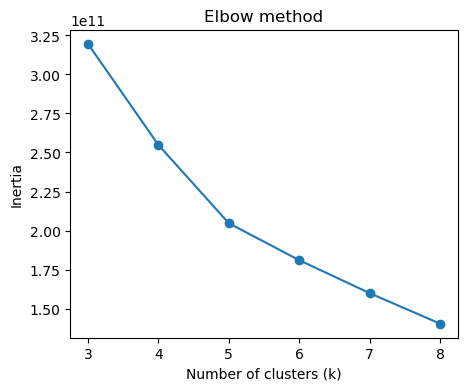

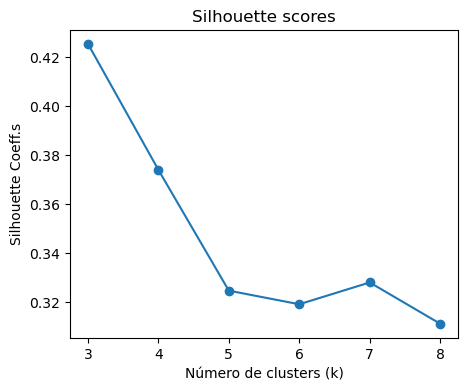

In [53]:
# ==== Model training and visualisation (tutorial-style layout) ====

# 1. Instantiate the object
# This creates an instance of the ClusteredStack class using the clipped raster
clustered_models = ClusteredStack(subset_path)

# Load the raster and reshape it into a 2D array of pixels × bands
clustered_models.set_raster_stack()

# 2. Define the range of k values (number of clusters to evaluate)
# Equivalent to testing k = 3, 4, ..., 8
ranges = np.arange(3, 9, 1)

# 3. Train the models
# For each k, this will:
# - Fit a KMeans model
# - Store the predicted labels
# - Compute inertia and silhouette scores
clustered_models.build_models(ranges)

# 4. Display the RGB preview again
# This step is optional but helps visually link the original image with the results
with rio.open(subset_path) as src:
    rgb_preview = src.read()                 # (bands, rows, cols)

plt.figure(figsize=(4,4))
plt.imshow(rgb)
plt.title("RGB (stretch 1-99 % por banda + gamma 0.7)")
plt.axis("off")
plt.show()

clustered_models.show_clustered()
clustered_models.show_inertia()

# --- Alias para mantener el nombre del tutorial ---
ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()

#### Selección del número de clusters (k)

Para determinar el k óptimo se evaluaron valores de 3 a 8 sobre el subset
de 800 × 800 px.  

* **Elbow (Inercia)**  
  La curva muestra una caída pronunciada hasta *k = 5*; a partir de ahí la
  pendiente se aplana, lo que indica que añadir más clusters aporta
  mejoras marginales de compacidad.
* **Silhouette score**  
  El coeficiente máximo se alcanza en *k = 3* pero disminuye gradualmente;
  en *k = 5* aún se conserva un valor aceptable (~0.33) antes de caer
  por debajo de 0.32 a *k ≥ 7*.

**Conclusión – k = 5:**  
*k = 5* representa el equilibrio óptimo entre compacidad de los clusters y
calidad de separación, evitando tanto la sub-segmentación (*k < 5*) como
la sobre-segmentación (*k > 5*).  
Por ello se adoptó *k = 5* para generar la banda de clusters que se
incorporará al stack multibanda y al segundo Random Forest.

### K= 5 for the whole image --> median_2018_sr_merged.tif

In [120]:
import rasterio
from rasterio.windows import Window
import numpy as np
from sklearn.cluster import KMeans
import os, math

# ── rutas ─────────────────────────────────────────────────────
in_img  = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"   # 6 bandas
out_km  = "/notebooks/WORKSHOP_3/results/clusters_k6.tif"       # ← nuevo nombre
tmp_dir = "/notebooks/WORKSHOP_3/tmp_kmeans_full"
os.makedirs(tmp_dir, exist_ok=True)

k = 6                    # ← k definitivo
sample_size = 120_000    # píxeles para entrenar K-Means
tile_size   = 1024       # ventana 1024 × 1024 px

# ── 1. Muestra aleatoria global ───────────────────────────────
with rasterio.open(in_img) as src:
    H, W = src.height, src.width
    total_pixels = H * W
    np.random.seed(42)
    idx = np.random.choice(total_pixels, sample_size, replace=False)
    rows = idx // W
    cols = idx %  W
    X_sample = np.empty((sample_size, 6), dtype=np.float32)
    for b in range(1, 7):
        band = src.read(b)
        X_sample[:, b-1] = band[rows, cols]

print("Muestra para entrenamiento:", X_sample.shape)

# ── 2. Entrenamiento K-Means ──────────────────────────────────
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
km.fit(X_sample)
print(f"Modelo K-Means entrenado con k = {k}")

# ── 3. Crear raster de salida y procesar por tiles ────────────
with rasterio.open(in_img) as src:
    profile = src.profile
profile.update(count=1, dtype="uint8", compress="lzw", tiled=True)

with rasterio.open(out_km, "w", **profile) as dst:
    tiles_x = math.ceil(profile["width"]  / tile_size)
    tiles_y = math.ceil(profile["height"] / tile_size)

    for ty in range(tiles_y):
        for tx in range(tiles_x):
            win = Window(
                col_off = tx * tile_size,
                row_off = ty * tile_size,
                width   = min(tile_size, profile["width"]  - tx*tile_size),
                height  = min(tile_size, profile["height"] - ty*tile_size)
            )

            with rasterio.open(in_img) as src:
                block = src.read(window=win).astype(np.float32)
            X_block = block.reshape(6, -1).T

            labels = km.predict(X_block).astype(np.uint8) + 1
            dst.write(labels.reshape(win.height, win.width), 1, window=win)

            print(f"Tile ({ty+1}/{tiles_y}, {tx+1}/{tiles_x}) listo")

print("\n✅  Mapa de clusters completo guardado →", out_km)

Muestra para entrenamiento: (120000, 6)
Modelo K-Means entrenado con k = 6
Tile (1/13, 1/14) listo
Tile (1/13, 2/14) listo
Tile (1/13, 3/14) listo
Tile (1/13, 4/14) listo
Tile (1/13, 5/14) listo
Tile (1/13, 6/14) listo
Tile (1/13, 7/14) listo
Tile (1/13, 8/14) listo
Tile (1/13, 9/14) listo
Tile (1/13, 10/14) listo
Tile (1/13, 11/14) listo
Tile (1/13, 12/14) listo
Tile (1/13, 13/14) listo
Tile (1/13, 14/14) listo
Tile (2/13, 1/14) listo
Tile (2/13, 2/14) listo
Tile (2/13, 3/14) listo
Tile (2/13, 4/14) listo
Tile (2/13, 5/14) listo
Tile (2/13, 6/14) listo
Tile (2/13, 7/14) listo
Tile (2/13, 8/14) listo
Tile (2/13, 9/14) listo
Tile (2/13, 10/14) listo
Tile (2/13, 11/14) listo
Tile (2/13, 12/14) listo
Tile (2/13, 13/14) listo
Tile (2/13, 14/14) listo
Tile (3/13, 1/14) listo
Tile (3/13, 2/14) listo
Tile (3/13, 3/14) listo
Tile (3/13, 4/14) listo
Tile (3/13, 5/14) listo
Tile (3/13, 6/14) listo
Tile (3/13, 7/14) listo
Tile (3/13, 8/14) listo
Tile (3/13, 9/14) listo
Tile (3/13, 10/14) listo
Ti

##### Generación de bandas «one-hot» para los clusters

La clasificación no supervisada con *k = 6* asignó a cada píxel un
identificador de cluster (1 – 6).  
Para incorporar esta información al Random Forest debemos transformar el
raster de etiquetas en **6 bandas binarias** (una por cluster):

| Nueva banda | Valor 1 | Valor 0 |
|-------------|---------|---------|
| `CL_1` | píxeles del cluster 1 | resto |
| `CL_2` | píxeles del cluster 2 | resto |
| … | … | … |
| `CL_6` | píxeles del cluster 6 | resto |

Finalmente se apilan las **6 bandas Sentinel-2** originales
(B2, B3, B4, B8, B11, B12) con estas **6 bandas one-hot**, obteniendo un
stack de **12 bandas** que servirá como insumo del segundo Random Forest.

In [3]:
import rasterio
from rasterio.windows import Window
import numpy as np
import math
import os

# --- rutas ----------------------------------------------------
s2_path  = "/notebooks/WORKSHOP_3/images/median_2018_sr_merged.tif"
cl_path  = "/notebooks/WORKSHOP_3/results/clusters_k6.tif"
out_path = "/notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif"

k = 6            # nº de clusters
tile = 1024      # tamaño de ventana

# --- metadatos de salida -------------------------------------
with rasterio.open(s2_path) as src:
    meta = src.meta.copy()
H, W = meta["height"], meta["width"]
meta.update(count=12, dtype="uint16", compress="lzw", tiled=True)

# --- escritura por bloques -----------------------------------
with rasterio.open(s2_path) as src_s2, \
     rasterio.open(cl_path) as src_cl, \
     rasterio.open(out_path, "w", **meta) as dst:

    tiles_x = math.ceil(W / tile)
    tiles_y = math.ceil(H / tile)

    for ty in range(tiles_y):
        for tx in range(tiles_x):

            win = Window(
                col_off = tx * tile,
                row_off = ty * tile,
                width   = min(tile, W - tx * tile),
                height  = min(tile, H - ty * tile)
            )

            # 1) copiar las 6 bandas originales
            s2_block = src_s2.read(window=win)
            dst.write(s2_block, window=win, indexes=range(1, 7))

            # 2) leer etiquetas de cluster y crear 6 máscaras
            labels = src_cl.read(1, window=win)
            masks  = np.zeros((k, win.height, win.width), dtype=np.uint16)
            for cid in range(1, k+1):
                masks[cid-1] = (labels == cid).astype(np.uint16)

            # escribir bandas 7-12
            dst.write(masks, window=win, indexes=range(7, 7+k))

        print(f"Fila de tiles {ty+1}/{tiles_y} completada")

print("✅  Stack de 12 bandas guardado →", out_path)

Fila de tiles 1/13 completada
Fila de tiles 2/13 completada
Fila de tiles 3/13 completada
Fila de tiles 4/13 completada
Fila de tiles 5/13 completada
Fila de tiles 6/13 completada
Fila de tiles 7/13 completada
Fila de tiles 8/13 completada
Fila de tiles 9/13 completada
Fila de tiles 10/13 completada
Fila de tiles 11/13 completada
Fila de tiles 12/13 completada
Fila de tiles 13/13 completada
✅  Stack de 12 bandas guardado → /notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif


⟡ Metadatos principales
  Dimensiones  : 13554 × 12631
  Bandas       : 12
  Tipo dato    : uint16
  CRS          : EPSG:4326
  Driver       : GTiff


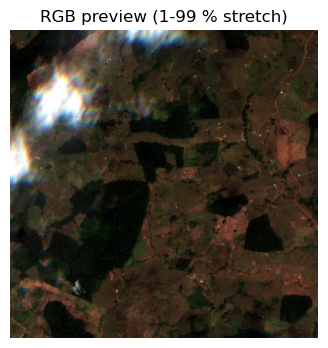

In [53]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

# ⇩⇩ Ajusta esta ruta si tu archivo está en otro directorio
stack_path = "/notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif"

# -- abrir y mostrar metadatos --
with rasterio.open(stack_path) as src:
    print("⟡ Metadatos principales")
    print("  Dimensiones  :", src.width, "×", src.height)
    print("  Bandas       :", src.count)
    print("  Tipo dato    :", src.dtypes[0])
    print("  CRS          :", src.crs)
    print("  Driver       :", src.driver)

    # -- ventana de 512×512 px para vista previa --
    w = 512
    win = Window(
        col_off = (src.width  - w)//2,
        row_off = (src.height - w)//2,
        width   = w,
        height  = w
    )
    # bandas 3-2-1 = R-G-B
    rgb = src.read([3, 2, 1], window=win).astype(np.float32)

# estirar 1-99 % para visualización
rgb_disp = np.empty_like(rgb)
for i in range(3):
    lo, hi = np.percentile(rgb[i], (1, 99))
    rgb_disp[i] = np.clip((rgb[i]-lo)/(hi-lo), 0, 1)

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(rgb_disp, (1,2,0)))
plt.title("RGB preview (1-99 % stretch)")
plt.axis("off")
plt.show()

## Random Forest Training (12 bands iamge)

In [54]:
'class_vec_sample_info' in globals()

True

In [55]:
# ============================================================
#  CONFIGURACIÓN DE RUTAS
# ============================================================
stack12 = "/notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif"   # 12-band stack
mask_tif = "/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"  # máscara 0/1 existente
vec_file = "/notebooks/WORKSHOP_3/datos_ent_val.gpkg"              # polígonos + puntos
out_cls  = "/notebooks/WORKSHOP_3/results/rf12_classification.kea" # salida
tmp_dir  = "/notebooks/WORKSHOP_3/tmp_training12"
os.makedirs(tmp_dir, exist_ok=True)

# ============================================================
#  DEFINIR INFORMACIÓN DE BANDAS
# ============================================================
from rsgislib.imageutils import ImageBandInfo
img_band_info = [ImageBandInfo(
    file_name = stack12,
    name      = "s2_full12",
    bands     = list(range(1, 13))  # 1-12
)]

# ============================================================
#  LISTA CON LAS CLASES Y CAPAS VECTORIALES
#      (reciclamos la que ya construiste: "class_vec_sample_info")
# ============================================================


# ============================================================
#  EXTRAER MUESTRAS PARA LAS 12 BANDAS
# ============================================================
from rsgislib.classification import get_class_training_data
cls_smpls_info = get_class_training_data(
    img_band_info=img_band_info,
    class_vec_sample_info=class_vec_sample_info,
    tmp_dir=tmp_dir
)

0) /notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif
Creating output image using input image
New image width = 13554 height = 12631 bands = 1


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input imageGet Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Get Image Min and Max.

Creating output image using input image
Get Im

In [56]:
import os, glob
tmp_dir = "/notebooks/WORKSHOP_3/tmp_training12"
glob.glob(os.path.join(tmp_dir, "*_smpls.h5"))

['/notebooks/WORKSHOP_3/tmp_training12/agricultural_areas_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/artificial_surfaces_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/clouds_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/forest_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/secondary_vegetation_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/shurb_and_herbaceous_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/sparsely_or_no_vegetated_areas_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/water_bodies_smpls.h5']

In [57]:
# --- Configuración básica ---
tmp_dir = "/notebooks/WORKSHOP_3/tmp_training12"      # carpeta donde guardar .h5
stack12 = "/notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif"  # imagen de 12 bandas

# --- Definir la imagen y sus 12 bandas ---
from rsgislib.imageutils import ImageBandInfo
img_band_info = [ImageBandInfo(
        file_name = stack12,
        name      = "s2_full12",
        bands     = list(range(1, 13))         # 1-12
)]

# --- Lista de clases que ya tenías en memoria ---
# (class_vec_sample_info contiene tus 8 objetos ClassVecSamplesInfoObj)
from rsgislib.classification import get_class_training_data

get_class_training_data(
    img_band_info          = img_band_info,
    class_vec_sample_info  = class_vec_sample_info,
    tmp_dir                = tmp_dir
)

print("✅  Ficheros *_smpls.h5 creados en", tmp_dir)

0) /notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif
Creating output image using input image
Running Rasterise now...New image width = 13554 height = 12631 bands = 1



Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image


Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.


Creating output image using input image
Running Rasterise now...

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Creating output image using input image
Running Rasterise now...


Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Col

In [58]:
import glob, os
glob.glob(os.path.join(tmp_dir, "*_smpls.h5"))

['/notebooks/WORKSHOP_3/tmp_training12/agricultural_areas_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/artificial_surfaces_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/clouds_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/forest_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/secondary_vegetation_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/shurb_and_herbaceous_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/sparsely_or_no_vegetated_areas_smpls.h5',
 '/notebooks/WORKSHOP_3/tmp_training12/water_bodies_smpls.h5']

In [59]:
from rsgislib.classification import create_train_valid_test_sets
import os

# a) Añadir a cada objeto las rutas de sus 4 ficheros
for cls in class_vec_sample_info:
    base = os.path.join(tmp_dir, f"{cls.class_name}_smpls")
    cls.file_h5       = f"{base}.h5"
    cls.train_file_h5 = f"{base}_train.h5"
    cls.valid_file_h5 = f"{base}_valid.h5"
    cls.test_file_h5  = f"{base}_test.h5"

# b) Diccionario requerido por rsgislib
cls_smpls_info = {cls.class_name: cls for cls in class_vec_sample_info}

# c) Crear (o recrear) los splits
create_train_valid_test_sets(
    cls_in_info  = cls_smpls_info,
    cls_out_info = cls_smpls_info,
    test_sample  = 200,
    valid_sample = 200,
    train_sample = None,
    rnd_seed     = 42
)

print("✅  train/valid/test .h5 generados correctamente")

✅  train/valid/test .h5 generados correctamente


In [60]:
# ==========================================================
# Entrenar Random Forest con 12 bandas
# ==========================================================
from rsgislib.classification.classsklearn import perform_sklearn_classifier_param_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump
from pathlib import Path

# --- búsqueda de hiperparámetros muy ligera  -------------
param_grid = {                     # prueba rápida
    "n_estimators": [100, 150],
    "max_depth"   : [10, 12]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    n_jobs  = -1,
    cv      = 3,
    verbose = 1
)

# cls_smpls_fnl_info ya apunta a los .h5 train/valid/test que acabamos de crear
sk_classifier = perform_sklearn_classifier_param_search(
    cls_smpls_fnl_info,
    grid_search
)

print("\n✅  Mejor score:", grid_search.best_score_)
print("💡  Parámetros :", grid_search.best_params_)

# --- guardar el modelo ---------------------------------------------
models_dir = Path("/notebooks/WORKSHOP_3/models")
models_dir.mkdir(exist_ok=True)
rf12_model_path = models_dir / "rf12_best.joblib"

dump(sk_classifier, rf12_model_path)
print(f"📁  Modelo guardado →  {rf12_model_path}")

Training data size: 1700 x 6
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best score was 0.8500061281765247 and has parameters {'max_depth': 12, 'n_estimators': 100}.

✅  Mejor score: 0.8500061281765247
💡  Parámetros : {'max_depth': 12, 'n_estimators': 100}
📁  Modelo guardado →  /notebooks/WORKSHOP_3/models/rf12_best.joblib


In [61]:
# --------------------------------------------------------------
# Convert existing cls_smpls_info  ➜  cls_smpls_fnl_info
# --------------------------------------------------------------
from rsgislib.classification import ClassInfoObj

# cls_smpls_info YA existe porque lo creaste en la celda 69
#                      (tiene las rutas *_train/valid/test.h5)
cls_smpls_fnl_info = {
    cls_name: ClassInfoObj(
        id=info.id,          # ID interno de la clase
        out_id=info.id,      # valor que saldrá en el raster
        train_file_h5=info.train_file_h5,
        valid_file_h5=info.valid_file_h5,
        test_file_h5=info.test_file_h5,
    )
    for cls_name, info in cls_smpls_info.items()
}

print("✅  cls_smpls_fnl_info construido con",
      len(cls_smpls_fnl_info), "clases.")

✅  cls_smpls_fnl_info construido con 8 clases.


In [62]:
from rsgislib.imageutils import ImageBandInfo
from rsgislib.classification import classsklearn
from pathlib import Path

# --- archivos de entrada / salida ---
stk_img   = "/notebooks/WORKSHOP_3/images/median_2018_sr_k6.tif"     # 12-band stack
mask_img  = "/notebooks/WORKSHOP_3/images/median_2018_sr_mask.tif"   # binary mask (1 = válido)

results_dir = Path("/notebooks/WORKSHOP_3/results")
results_dir.mkdir(exist_ok=True)
class_img  = results_dir / "rf12_classification.kea"

# --- info de bandas (todas las 12) ---
band_info = [ImageBandInfo(file_name=stk_img,
                           bands=list(range(1, 13)),
                           name="S2_SR_K6")]


# 5½.  Renumber class IDs to be consecutive 0…n-1
from rsgislib.classification import ClassInfoObj

cls_smpls_fnl_info = {}
for new_id, (name, info) in enumerate(sorted(cls_smpls_info.items())):
    cls_smpls_fnl_info[name] = ClassInfoObj(
        id=new_id,           # 0,1,2…
        out_id=new_id,       # valor en el raster
        train_file_h5=info.train_file_h5,
        valid_file_h5=info.valid_file_h5,
        test_file_h5 =info.test_file_h5,
    )

print("✅  IDs renumerados de forma consecutiva:")
for n, i in cls_smpls_fnl_info.items():
    print(f"  {n:20s}  →  id={i.id}")

✅  IDs renumerados de forma consecutiva:
  agricultural_areas    →  id=0
  artificial_surfaces   →  id=1
  clouds                →  id=2
  forest                →  id=3
  secondary_vegetation  →  id=4
  shurb_and_herbaceous  →  id=5
  sparsely_or_no_vegetated_areas  →  id=6
  water_bodies          →  id=7


In [78]:
# Añadir colores a cada ClassInfoObj  --------------------------
palette = [
    (166, 97, 26),   # id 0 - agricultural_areas   (marrón)
    (0,   112, 255), # id 1 - artificial_surfaces  (azul)
    (255, 255, 255), # id 2 - clouds               (blanco)
    (0,   128, 0),   # id 3 - forest               (verde)
    (140, 200, 80),  # id 4 - secondary_vegetation (verde claro)
    (233, 182, 60),  # id 5 - shrub_and_herbaceous (ocre)
    (200, 200, 200), # id 6 - sparsely/no_veg      (gris claro)
    (0,   175, 206), # id 7 - water_bodies         (cian)
]

for cls_name, cls_obj in cls_smpls_fnl_info.items():
    r, g, b = palette[cls_obj.id]
    cls_obj.red   = r
    cls_obj.green = g
    cls_obj.blue  = b


# --- aplicar clasificador ---
classsklearn.apply_sklearn_classifier(
    cls_train_info = cls_smpls_fnl_info,
    sk_classifier  = sk_classifier,
    in_msk_img     = mask_img,
    img_msk_val    = 1,               # píxeles 1 = válidos
    img_file_info  = band_info,
    out_class_img  = str(class_img),
    gdalformat     = "KEA"
)

print("✅  Clasificación creada en:", class_img)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'agricultural_areas'
Apply Colour to class 'artificial_surfaces'
Apply Colour to class 'clouds'
Apply Colour to class 'forest'
Apply Colour to class 'secondary_vegetation'
Apply Colour to class 'shurb_and_herbaceous'
Apply Colour to class 'sparsely_or_no_vegetated_areas'
Apply Colour to class 'water_bodies'
✅  Clasificación creada en: /notebooks/WORKSHOP_3/results/rf12_classification.kea


### Visaulización de resultados RF2

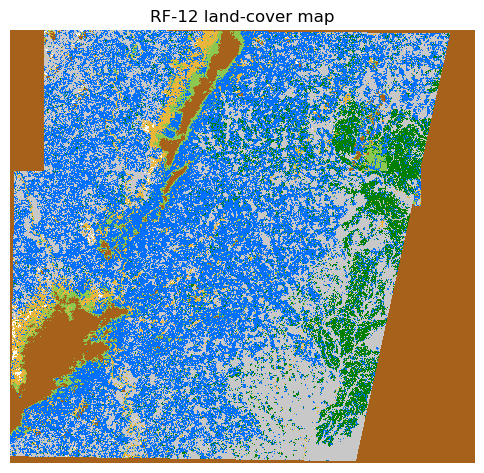

In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class_img = "/notebooks/WORKSHOP_3/results/rf12_classification.kea"

with rasterio.open(class_img) as src:
    arr = src.read(1)
    # ← recupera la tabla de colores que acabamos de grabar
    ct = src.colormap(1)                 # dict {id: (r,g,b,a)}
    max_key = max(ct.keys())
    colors = [(0,0,0,0)] * (max_key + 1) # fondo transparente
    for k, (r, g, b, a) in ct.items():
        colors[k] = (r/255, g/255, b/255, 1)
    cmap = ListedColormap(colors)

plt.figure(figsize=(6,6))
plt.imshow(arr, cmap=cmap, interpolation="nearest")
plt.title("RF-12 land-cover map")
plt.axis("off")
plt.show()

### Matriz de confusión RF2

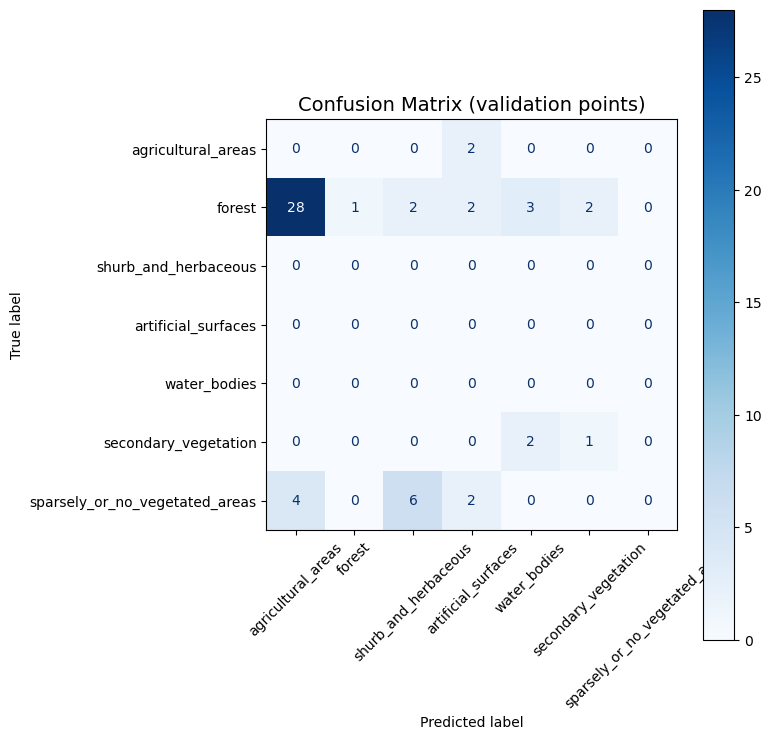

In [64]:
# ── Confusion Matrix (RF-12) ──────────────────────────────────────────
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# — 1. Rutas y parámetros —
class_img = "/notebooks/WORKSHOP_3/results/rf12_classification.kea"
val_pts   = "/notebooks/WORKSHOP_3/datos_ent_val.gpkg"
layer     = "testing"
col_cls   = "Name"           # campo con la clase real (string)

# — 2. Leer puntos y etiquetas reales —
gdf    = gpd.read_file(val_pts, layer=layer)
y_true = gdf[col_cls].values
coords = list(zip(gdf.geometry.x, gdf.geometry.y))

# — 3. Obtener valor predicho para cada punto (sin leer toda la banda) —
with rasterio.open(class_img) as src:
    y_pred_ids = [val[0] for val in src.sample(coords)]

# — 4. Mapear ID ↔ nombre de clase —
code_to_name = {obj.id: name for name, obj in cls_smpls_fnl_info.items()}
y_pred  = np.array([code_to_name.get(pid, "unknown") for pid in y_pred_ids])
labels  = [code_to_name[i] for i in sorted(code_to_name)]

# — 5. Matriz de confusión + gráfico —
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(
    ax=ax, cmap="Blues", xticks_rotation=45
)
ax.set_title("Confusion Matrix (validation points)", fontsize=14)
plt.tight_layout()
plt.show()

### Métricas RF2

In [65]:
# ── Metrics for RF-12 ────────────────────────────────────────────────
from sklearn.metrics import (classification_report, accuracy_score,
                             cohen_kappa_score)
import pandas as pd

# y_true, y_pred, labels ya existen del bloque anterior
oa    = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred, labels=labels)

report_df = (pd.DataFrame(
                 classification_report(y_true, y_pred,
                                       labels=labels,
                                       output_dict=True,
                                       zero_division=0)
             ).T
             .round(2))

print(f"✅  Overall Accuracy: {oa:.2f}   |   Kappa: {kappa:.2f}")
display(report_df)

# (opcional) guardar CSV para tu informe / Git
report_df.to_csv("/notebooks/WORKSHOP_3/results/acc_rf12/rf12_metrics.csv")
print("📝  CSV guardado en results/acc_rf12/rf12_metrics.csv")

✅  Overall Accuracy: 0.03   |   Kappa: -0.00


,precision,recall,f1-score,support
agricultural_areas,0.00,0.00,0.00,3.0
forest,1.00,0.02,0.04,44.0
shurb_and_herbaceous,0.00,0.00,0.00,0.0
artificial_surfaces,0.00,0.00,0.00,0.0
water_bodies,0.00,0.00,0.00,0.0
secondary_vegetation,0.12,0.33,0.18,3.0
sparsely_or_no_vegetated_areas,0.00,0.00,0.00,16.0
micro avg,0.03,0.03,0.03,66.0
macro avg,0.16,0.05,0.03,66.0
weighted avg,0.67,0.03,0.04,66.0


📝  CSV guardado en results/acc_rf12/rf12_metrics.csv


## Comparación de Modelos

In [ ]:
import pandas as pd

comp_df = pd.DataFrame({
    "Model": ["RF-6 (6 bands)", "RF-12 (12 bands)"],
    "OverallAccuracy": [oa6, oa],
    "Kappa":           [kap6, kappa]
}).set_index("Model").round(3)

print("🔸  Comparison RF-6 vs RF-12")
display(comp_df)